In [1]:
import os
import h5py
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import numpy as np
import gc
gc.enable() 
montage3d = lambda x, **k: montage2d(np.stack([montage2d(y, **k) for y in x],0))
data_dir = '../input/mri-heart-processing/'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with h5py.File(os.path.join(data_dir, 'train_mri_128_128.h5'), 'r') as w:
    full_data = w['image'].value
    n_group = w['id'].value
    n_scalar = w['area_multiplier'].value
    y_target = w['systole'].value / n_scalar 

In [3]:
y_target.min(), y_target.max(), y_target.mean()

(7.989728395061729, 311.5552329801132, 65.78827203912246)

In [4]:
offset_value = 0
scale_factor = 1
clip_min = -9999
clip_max = 9999

(1771, 1)

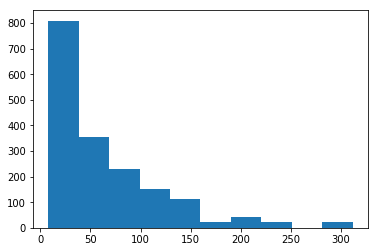

In [5]:
y_target_class = ((y_target-offset_value)/scale_factor).clip(clip_min, clip_max).reshape((-1,1))
_ = plt.hist(y_target_class)
y_target_class.shape

In [6]:
# instance normalization
safe_norm_func = lambda x: np.clip((x-x.mean())/(0.1+x.std()), -2, 2)
norm_ch_x_data = np.apply_along_axis(safe_norm_func, 0, (full_data.swapaxes(1,3).swapaxes(1,2)))
del full_data
norm_ch_x_data.shape

(1771, 128, 128, 30)

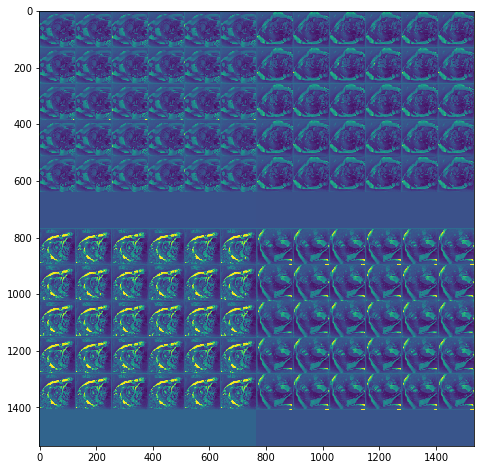

In [7]:
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.imshow(montage3d(norm_ch_x_data[np.random.choice(norm_ch_x_data.shape[0], size = 4)].swapaxes(1,3)))

(array([  9424., 250121., 493616., 355581., 196703., 121968.,  94746.,
         81023.,  73877., 289021.]),
 array([-0.77723508, -0.49951157, -0.22178806,  0.05593545,  0.33365895,
         0.61138246,  0.88910597,  1.16682948,  1.44455298,  1.72227649,
         2.        ]),
 <a list of 10 Patch objects>)

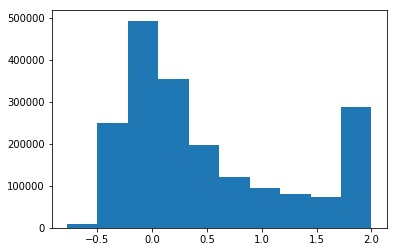

In [8]:
%matplotlib inline
plt.hist(norm_ch_x_data[:4].ravel())

In [9]:
from keras.models import Sequential
from keras.layers import SpatialDropout2D, Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Reshape, GlobalAveragePooling2D, MaxPooling2D

In [10]:
in_shape = norm_ch_x_data.shape[1:]

In [11]:
simple_model = Sequential()
simple_model.add(Conv2D(filters = 32, 
                        kernel_size = (1,1), 
                        input_shape = in_shape, 
                        activation = 'linear',
                       use_bias = False))
simple_model.add(BatchNormalization())
simple_model.add(Activation('relu'))
simple_model.add(Conv2D(filters = 64, kernel_size = (3,3)))
simple_model.add(Conv2D(filters = 64, kernel_size = (3,3)))
simple_model.add(MaxPooling2D((2,2)))
simple_model.add(Conv2D(filters = 128, kernel_size = (3,3)))
simple_model.add(Conv2D(filters = 128, kernel_size = (3,3)))
simple_model.add(MaxPooling2D((2,2)))
simple_model.add(Conv2D(filters = 256, kernel_size = (3,3)))
simple_model.add(MaxPooling2D((2,2)))
simple_model.add(Conv2D(filters = 512, kernel_size = (3,3)))
simple_model.add(Conv2D(filters = 1024, kernel_size = (1,1)))
simple_model.add(GlobalAveragePooling2D())
simple_model.add(Dropout(0.25))
simple_model.add(Dense(512, activation = 'tanh'))
simple_model.add(Dropout(0.1))
simple_model.add(Dense(y_target_class.shape[1], activation = 'linear'))
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      960       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 128)       73856     
__________

In [12]:
from keras.optimizers import Adam
simple_model.compile(loss = 'mae', 
                     optimizer = Adam(1e-4, decay = 1e-6), 
                     metrics = ['mae', 'mse'])
loss_history = []

In [13]:
from sklearn.model_selection import train_test_split
# a simpler one is better here since the same patients are spread over multiple slices and we want to minimize leak without making too much hassle
def train_test_split(x, y, train_size, random_state):
    last_train_idx = int(train_size*x.shape[0])
    return x[:last_train_idx], x[last_train_idx+1:], y[:last_train_idx], y[last_train_idx+1:]
X_train, X_test, y_train, y_test = train_test_split(norm_ch_x_data, y_target_class, 
                                                   train_size = 0.7,
                                                   random_state = 2017)
del norm_ch_x_data

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('systole_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/callbacks.py:919: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.


In [15]:
loss_history += [simple_model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
                           shuffle = True,
                           batch_size = 32,
                           epochs = 30,
                                 callbacks = callbacks_list)]

Train on 1239 samples, validate on 531 samples
Epoch 1/30
1239/1239 [==============================] - 39s 31ms/step - loss: 47.6687 - mean_absolute_error: 47.6687 - mean_squared_error: 5719.2887 - val_loss: 35.2690 - val_mean_absolute_error: 35.2690 - val_mean_squared_error: 3033.9539

Epoch 00001: val_loss improved from inf to 35.26904, saving model to systole_model_weights.best.hdf5
Epoch 2/30
1239/1239 [==============================] - 32s 26ms/step - loss: 43.1772 - mean_absolute_error: 43.1772 - mean_squared_error: 5061.4569 - val_loss: 34.5546 - val_mean_absolute_error: 34.5546 - val_mean_squared_error: 2934.9074

Epoch 00002: val_loss improved from 35.26904 to 34.55461, saving model to systole_model_weights.best.hdf5
Epoch 3/30
1239/1239 [==============================] - 32s 26ms/step - loss: 42.7005 - mean_absolute_error: 42.7005 - mean_squared_error: 4941.8837 - val_loss: 33.9970 - val_mean_absolute_error: 33.9970 - val_mean_squared_error: 2845.2242

Epoch 00003: val_loss i

1239/1239 [==============================] - 32s 26ms/step - loss: 39.4258 - mean_absolute_error: 39.4258 - mean_squared_error: 4122.8810 - val_loss: 31.1788 - val_mean_absolute_error: 31.1788 - val_mean_squared_error: 2257.1853

Epoch 00025: val_loss improved from 31.31731 to 31.17877, saving model to systole_model_weights.best.hdf5
Epoch 26/30
1239/1239 [==============================] - 31s 25ms/step - loss: 39.5519 - mean_absolute_error: 39.5519 - mean_squared_error: 4103.2375 - val_loss: 30.9375 - val_mean_absolute_error: 30.9375 - val_mean_squared_error: 2228.1520

Epoch 00026: val_loss improved from 31.17877 to 30.93748, saving model to systole_model_weights.best.hdf5
Epoch 27/30
1239/1239 [==============================] - 32s 26ms/step - loss: 39.3192 - mean_absolute_error: 39.3192 - mean_squared_error: 4101.1218 - val_loss: 31.0594 - val_mean_absolute_error: 31.0594 - val_mean_squared_error: 2213.6229

Epoch 00027: val_loss did not improve
Epoch 28/30
1239/1239 [=============

In [16]:
simple_model.load_weights(weight_path)
simple_model.save('full_systolic_model.h5')

531/531 [==============================] - 9s 18ms/step


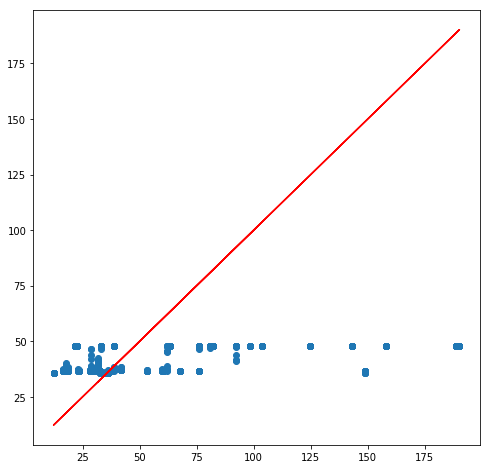

In [17]:
pred_test = simple_model.predict(X_test, verbose = 1)
fig, (ax1) = plt.subplots(1,1, figsize = (8, 8))
ax1.scatter(y_test, pred_test)
ax1.plot(y_test, y_test, 'r-')

In [18]:
for v, f in zip(simple_model.evaluate(X_test, y_test, verbose = 1), 
                simple_model.metrics_names):
    print('{}: difference - {:2.2f}ml'.format(f, scale_factor*v))

531/531 [==============================] - 9s 17ms/step
loss: difference - 30.70ml
mean_absolute_error: difference - 30.70ml
mean_squared_error: difference - 2177.49ml


(****vol of blood pumped out of ventrical per)/( total vol of blood in ventrical at end of diastole) = ejection fraction(%)

if ef>75:
    hr_cond="Hyperdynamic"
elif ef in range(55,65):
    hr_cond="Normal EF"
elif ef in range(45,55):
    hr_cond="Mildly Abormal"
elif ef in range(35,45):
    hr_cond="Moderately Abnormal"
elif ef<35:
    hr_cond="Severely Abnormal"